In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pickle

import xgboost as xgb 
from xgboost import plot_importance

In [2]:
df = pd.read_csv("PJME_hourly.csv")
df = df.set_index("Datetime")
df.index = pd.to_datetime(df.index)

df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


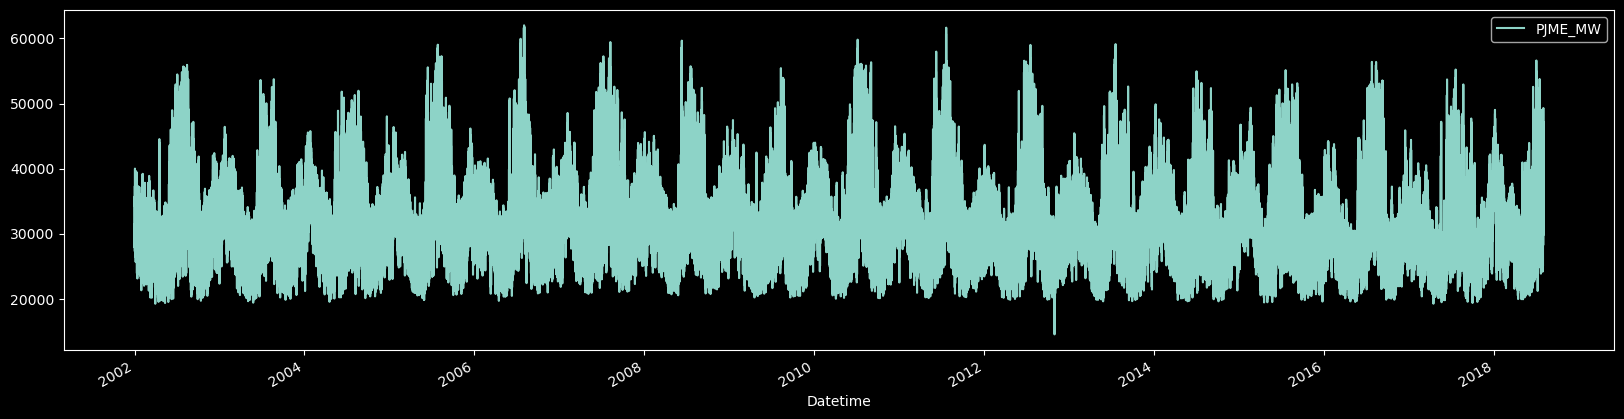

In [3]:
df.plot(figsize=(20, 5))
plt.show()

<Axes: xlabel='Datetime'>

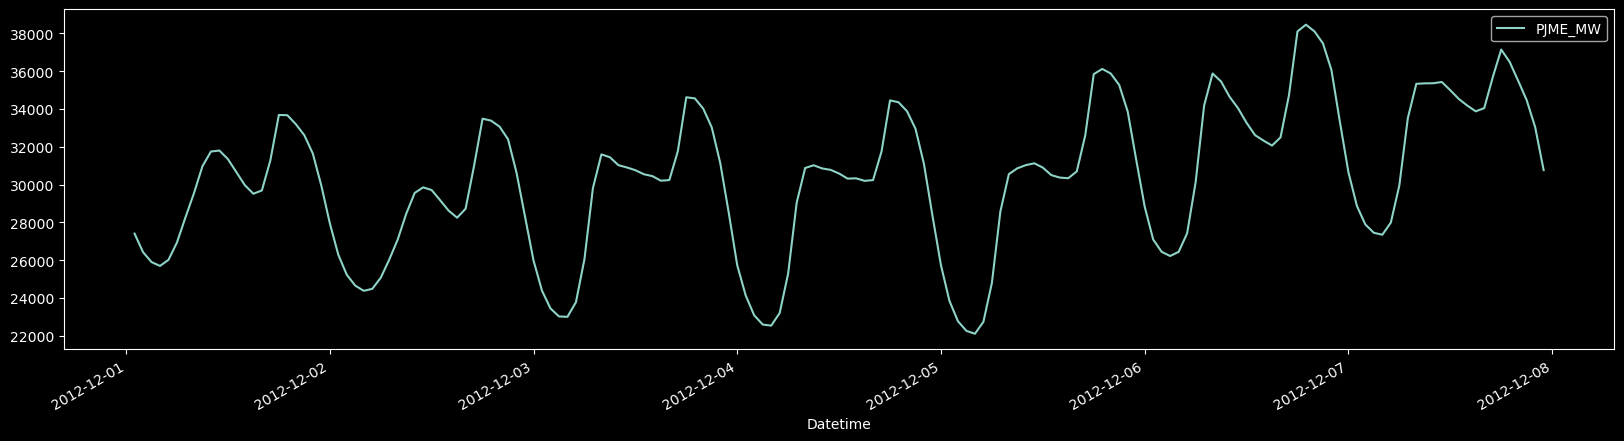

In [4]:
#weekly energy use
df.loc[(df.index > '12-01-2012') & (df.index < '12-08-2012')].plot(figsize=(20,5))

In [25]:
def create_features(df, label=None):
    df['date'] = df.index
 
    df['hour'] = df['date'].dt.hour
    df["day"] = df["date"].dt.day
    df["month"] = df["date"].dt.month
    df['year'] = df['date'].dt.year
    
    
    X = df[['hour', 'day', 'month', 'year']]
    if label:
        y = df[label]
        return X, y
    return X

split_date = '01-Jan-2014'
pjme_train = df.loc[df.index <= split_date].copy()
pjme_test = df.loc[df.index > split_date].copy()

X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

Datetime
2002-12-31 01:00:00    26498.0
2002-12-31 02:00:00    25147.0
2002-12-31 03:00:00    24574.0
2002-12-31 04:00:00    24393.0
2002-12-31 05:00:00    24860.0
                        ...   
2013-01-01 20:00:00    35625.0
2013-01-01 21:00:00    34950.0
2013-01-01 22:00:00    33489.0
2013-01-01 23:00:00    31285.0
2013-01-02 00:00:00    29275.0
Name: PJME_MW, Length: 105167, dtype: float64

In [6]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False)

c:\Users\hilla\anaconda3\envs\machine\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

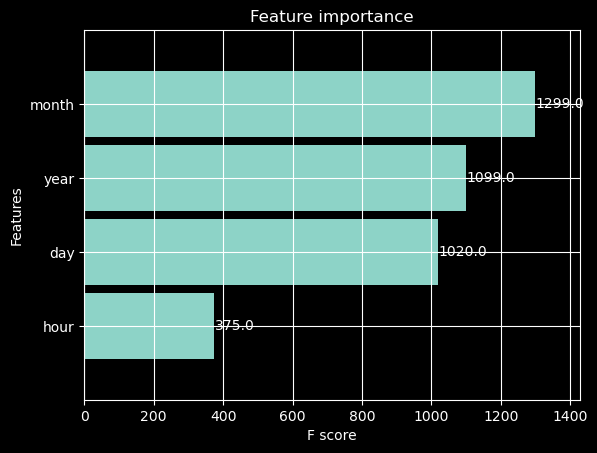

In [7]:
plot_importance(reg, height=0.9)

<Axes: xlabel='Datetime'>

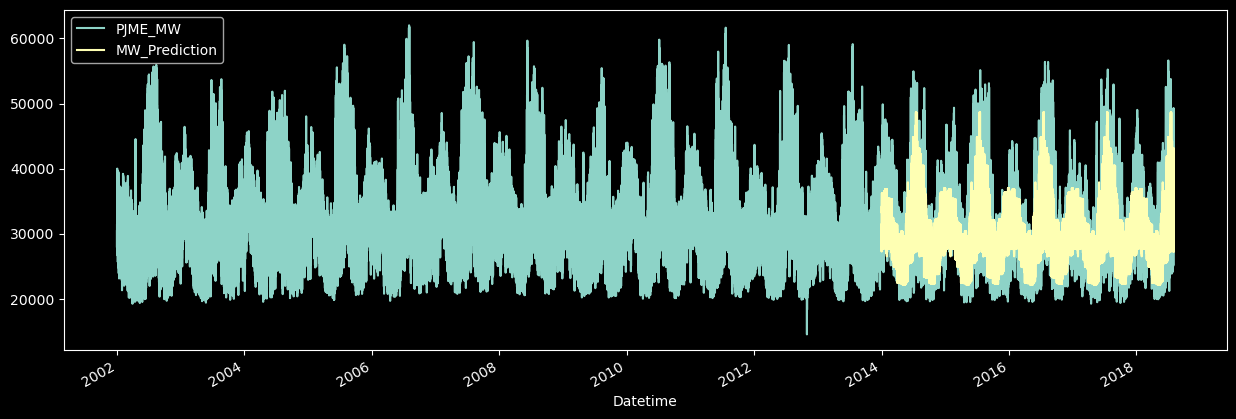

In [8]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

In [9]:
def mae(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mae(y_test, reg.predict(X_test))

9.371755334686368

In [10]:
with open('xgboost.pkl', 'wb') as f:
    pickle.dump(reg, f)

In [13]:
print(reg.predict(X_test))

[27614.354 26818.877 27478.19  ... 31886.47  30765.436 29551.854]


In [14]:
print(y_test)

Datetime
2014-12-31 01:00:00    30795.0
2014-12-31 02:00:00    29995.0
2014-12-31 03:00:00    29688.0
2014-12-31 04:00:00    29767.0
2014-12-31 05:00:00    30426.0
                        ...   
2018-01-01 20:00:00    44284.0
2018-01-01 21:00:00    43751.0
2018-01-01 22:00:00    42402.0
2018-01-01 23:00:00    40164.0
2018-01-02 00:00:00    38608.0
Name: PJME_MW, Length: 40199, dtype: float64
